In [157]:
import numpy as np
from mnist import MNIST
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# kmeans
## init

Randomly pick 10 images as starting points.

In [6]:
def init(k, data, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, data.shape[1]))
    n_rows = data.shape[0]
    for rand in range(k):
        idx = np.random.choice(n_rows)
        mu[rand] = data[idx]
    return mu

`init_dist` takes into account the distances of different points when picking stating mu's.

def init_dist(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    memmap = '../data/mnist/dist.memmap'
    fp = np.memmap(memmap, dtype='float32', shape=(n_rows, n_rows - 10000), mode='r')
    
    ids = []
    img_id = np.random.choice(n_rows)
    ids.append(img_id)
    mu[0] = images[img_id]
    for rand in range(1, k):
        distances = fp[img_id].copy()
        img_id = np.argmax(distances)
        while img_id in ids:
            distances[img_id] = -1
            img_id = np.argmax(distances)
        mu[rand] = images[img_id]
        ids.append(img_id)        
    del fp
    
    return mu

## E step
Assign memberships from current mu's. <br>
Also evaluate loss

In [7]:
def e_step(mu, data):
    distances = np.matrix(euclidean_distances(X=data, Y=mu))
    loss = np.sum(distances.min(axis=1))
    return np.array(distances.argmin(1).T).ravel(), loss

## M step
Calculate new mu's from current memberships

In [8]:
def m_step(pi, k, data):
    mu = np.empty((k, data.shape[1]))
    for cluster_id in range(k):
        cluster_data = data[np.where(pi == cluster_id)[0]]
        mu[cluster_id] = np.mean(cluster_data, axis=0)
    return mu

## external metrics

Helper function to get confusion matrix and cluster mappings for `k` and `pi`'s

In [122]:
def get_confusion_matrix(k, pi, labels):
    conf_mat = np.empty(shape=(k, len(np.unique(labels))))
    for cluster_id in range(k):
        true_labels = labels[np.where(cluster_id == pi)]
        conf_mat[cluster_id] = np.bincount(true_labels, minlength=10)
    conf_mat = np.array(conf_mat)
    return conf_mat

### Purity

In [51]:
def purity(confusion_matrix):
#     print(confusion_matrix)
    Pj = confusion_matrix.max(axis=1)
    Mj = confusion_matrix.sum(axis=1)
    return sum(Pj)/sum(Mj)

### Gini

In [33]:
def gini(confusion_matrix):
    Mj = confusion_matrix.sum(axis=1, keepdims=True)
    gj = 1 - ((confusion_matrix/Mj)**2).sum(axis=1, keepdims=True)
    return (sum(gj*Mj)/sum(Mj))[0]

## k means helper

In [132]:
def kmeans(data, labels, k, init_func, max_epochs, print_interval, seed):
    _loss, _purity, _gini = [], [], []
    
    # initial mu values
    _mu = init_func(k, data, seed)
    
    for _epoch in range(max_epochs):
        # e step
        _pi, loss = e_step(_mu, data)
        # m step
        mu = m_step(_pi, k, data)
        
        # evaluation
        conf_mat = get_confusion_matrix(k, _pi, labels)
        p = purity(conf_mat)
        g = gini(conf_mat)
        
        # append to global
        _purity.append(p)
        _gini.append(g)
        _loss.append(loss)
        
        # print info
        if _epoch % print_interval == 0:
            print('\tEpoch:', _epoch, 'Loss:', loss, 
                  'Purity:', p, 'Gini Index:', g)
                
        # check for convergence
        if np.allclose(_mu, mu):
            print('\tConvergence at epoch {0}, Loss at {1}'.format(_epoch, loss))
            break
        _mu = mu
        if _epoch == (max_epochs - 1):
            print('\tNo convergence after {0} epochs, try higher value. Loss at {1}'.format(max_epochs, loss))
            
    return _loss, _purity, _gini

## graph helpers

In [35]:
def graph_helper_loss(loss):
    plt.plot(range(len(loss)), np.log(loss))
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log_10)')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [36]:
def graph_helper_metrics(purity, gini):
    plt.plot(range(len(gini)), gini, 'r', label = 'Gini Index')
    plt.plot(range(len(purity)), purity, 'g', label = 'Purity')
    plt.xlabel('Epochs')
    plt.ylabel('Gini Index/Purity')
    plt.title('Gini Index/Purity vs Epochs')
    plt.legend()
    plt.show()

## All together

In [128]:
def do_kmeans(data, labels, ks):
    seed = np.random.randint(np.random.randint(data.shape[0]))
    
    for k in ks:
        print('For k = {0}:'.format(k))
        t_loss, t_purity, t_gini = kmeans(data=data, labels=labels,
                                          k=k, init_func=init, 
                                          max_epochs=150, 
                                          print_interval=10, 
                                          seed=seed)
        
        print('\n\tFinal values: \n\t\tLoss: {0}'.format(t_loss[-1]))
        print('\t\tPurity: {0}'.format(t_purity[-1]))
        print('\t\tGini Index: {0}\n'.format(t_gini[-1]))
        
        graph_helper_loss(t_loss)
        graph_helper_metrics(t_purity, t_gini)

# MNIST

In [2]:
mnist_loader = MNIST("../data/mnist/")
mnist_loader.gz = True

In [3]:
images, labels = mnist_loader.load_training()

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
images.shape

(60000, 784)

For k = 10:
	Epoch: 0 Loss: 127472313.557 Purity: 0.379383333333 Gini Index: 0.748255469431
	Epoch: 10 Loss: 94224916.5016 Purity: 0.577533333333 Gini Index: 0.55532368486
	Epoch: 20 Loss: 94187430.4992 Purity: 0.578233333333 Gini Index: 0.553347714858
	Epoch: 30 Loss: 94187032.1978 Purity: 0.577533333333 Gini Index: 0.554170796399
	Epoch: 40 Loss: 94186982.6641 Purity: 0.57705 Gini Index: 0.55466961234
	Epoch: 50 Loss: 94187491.6132 Purity: 0.577 Gini Index: 0.555105920957
	Convergence at epoch 55, Loss at 94187376.91543944

	Final values: 
		Loss: 94187376.91543944
		Purity: 0.5770833333333333
		Gini Index: 0.5550979707897774



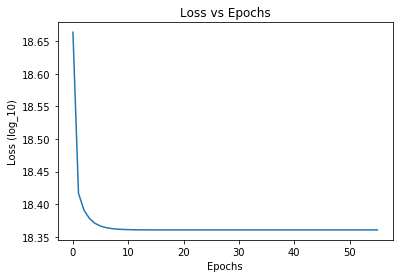

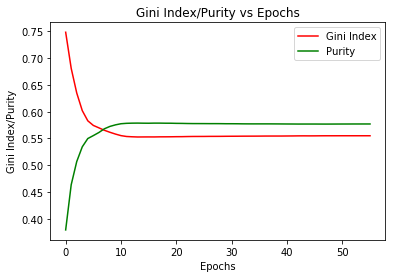

For k = 5:
	Epoch: 0 Loss: 134596906.652 Purity: 0.284066666667 Gini Index: 0.814250001086
	Epoch: 10 Loss: 100368919.511 Purity: 0.366933333333 Gini Index: 0.73594931587
	Epoch: 20 Loss: 100001954.814 Purity: 0.42695 Gini Index: 0.703510237074
	Epoch: 30 Loss: 99619688.4246 Purity: 0.4518 Gini Index: 0.659926061569
	Epoch: 40 Loss: 99608063.178 Purity: 0.452316666667 Gini Index: 0.658455101921
	Convergence at epoch 44, Loss at 99607939.5522335

	Final values: 
		Loss: 99607939.5522335
		Purity: 0.45231666666666664
		Gini Index: 0.6584749920560773



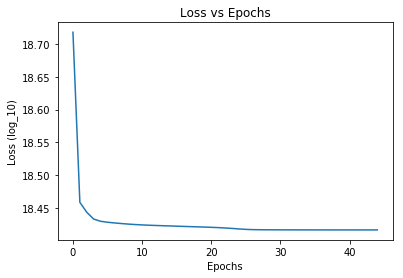

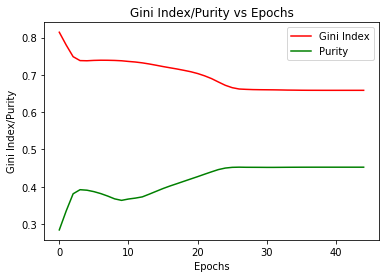

For k = 20:
	Epoch: 0 Loss: 116334432.33 Purity: 0.542933333333 Gini Index: 0.617421987857
	Epoch: 10 Loss: 90039512.5682 Purity: 0.693133333333 Gini Index: 0.412109647084
	Epoch: 20 Loss: 89037335.9978 Purity: 0.706166666667 Gini Index: 0.400044754175
	Epoch: 30 Loss: 89025935.218 Purity: 0.706966666667 Gini Index: 0.402038052918
	Epoch: 40 Loss: 89026512.6425 Purity: 0.707333333333 Gini Index: 0.402575128929
	Epoch: 50 Loss: 89026872.3765 Purity: 0.70765 Gini Index: 0.402541305255
	Convergence at epoch 53, Loss at 89026902.50283724

	Final values: 
		Loss: 89026902.50283724
		Purity: 0.7076333333333333
		Gini Index: 0.4025717013252343



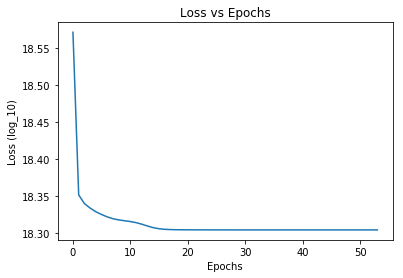

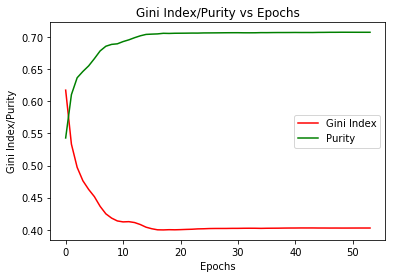

In [133]:
do_kmeans(images, labels, [10, 5, 20])

In [154]:
# cleanup
del images, labels

# FASHION

In [136]:
fashion = pd.read_csv('../data/fashion/fashion-mnist_train.csv')

In [140]:
f_labels = fashion['label']
del fashion['label']

In [152]:
f_labels = f_labels.values

In [145]:
fashion = fashion.values

In [147]:
fashion.shape, f_labels.shape

((60000, 784), (60000,))

For k = 10:
	Epoch: 0 Loss: 123354292.434 Purity: 0.425216666667 Gini Index: 0.672648770921
	Epoch: 10 Loss: 84384540.6898 Purity: 0.5903 Gini Index: 0.529029812791
	Epoch: 20 Loss: 84295354.3409 Purity: 0.592383333333 Gini Index: 0.526606874411
	Epoch: 30 Loss: 84298851.2673 Purity: 0.589216666667 Gini Index: 0.529291895234
	Epoch: 40 Loss: 84301594.197 Purity: 0.587433333333 Gini Index: 0.530969548139
	Epoch: 50 Loss: 84303936.2553 Purity: 0.586116666667 Gini Index: 0.532070452834
	Epoch: 60 Loss: 84303904.1022 Purity: 0.585883333333 Gini Index: 0.53227077576
	Convergence at epoch 60, Loss at 84303904.1022216

	Final values: 
		Loss: 84303904.1022216
		Purity: 0.5858833333333333
		Gini Index: 0.5322707757595355



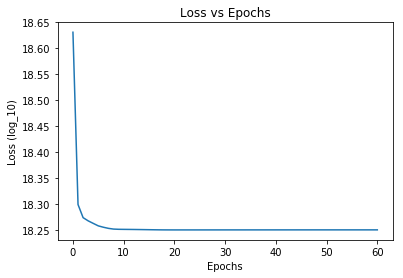

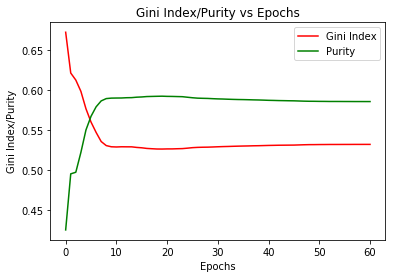

For k = 5:
	Epoch: 0 Loss: 139820742.949 Purity: 0.2735 Gini Index: 0.796768167243
	Epoch: 10 Loss: 94257053.1674 Purity: 0.353333333333 Gini Index: 0.728831096802
	Epoch: 20 Loss: 93447587.4024 Purity: 0.408016666667 Gini Index: 0.713459605916
	Epoch: 30 Loss: 93357781.7942 Purity: 0.411466666667 Gini Index: 0.705678992761
	Epoch: 40 Loss: 93366131.0565 Purity: 0.410533333333 Gini Index: 0.706795188171
	Epoch: 50 Loss: 93367457.6767 Purity: 0.4106 Gini Index: 0.70675346253
	Convergence at epoch 53, Loss at 93367467.72720176

	Final values: 
		Loss: 93367467.72720176
		Purity: 0.4106
		Gini Index: 0.7067565018716232



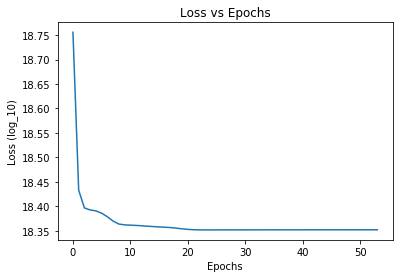

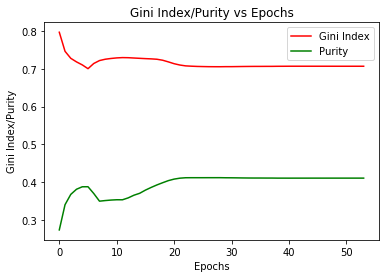

For k = 20:
	Epoch: 0 Loss: 109157567.713 Purity: 0.588316666667 Gini Index: 0.541406471171
	Epoch: 10 Loss: 77706045.59 Purity: 0.660216666667 Gini Index: 0.455728701474
	Epoch: 20 Loss: 77125098.6319 Purity: 0.653233333333 Gini Index: 0.451559694239
	Epoch: 30 Loss: 77108299.2637 Purity: 0.654716666667 Gini Index: 0.447929098459
	Epoch: 40 Loss: 77112967.7487 Purity: 0.6564 Gini Index: 0.446998932804
	Epoch: 50 Loss: 77118216.2467 Purity: 0.657566666667 Gini Index: 0.446756475566
	Epoch: 60 Loss: 77122088.2992 Purity: 0.65775 Gini Index: 0.44703971823
	Epoch: 70 Loss: 77125393.9908 Purity: 0.6583 Gini Index: 0.447193796178
	Epoch: 80 Loss: 77128947.4305 Purity: 0.659 Gini Index: 0.447616826814
	Epoch: 90 Loss: 77131661.5887 Purity: 0.65855 Gini Index: 0.448475583234
	Epoch: 100 Loss: 77132936.6083 Purity: 0.658716666667 Gini Index: 0.448798205484
	Epoch: 110 Loss: 77134249.9939 Purity: 0.659033333333 Gini Index: 0.448667146202
	Epoch: 120 Loss: 77135513.5637 Purity: 0.65925 Gini Inde

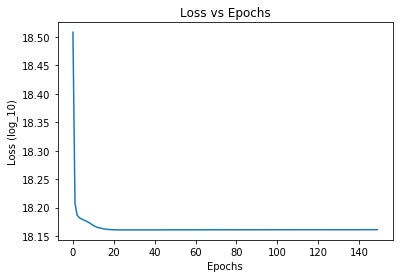

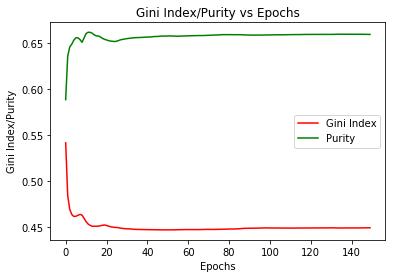

In [153]:
do_kmeans(data=fashion, labels=f_labels, ks=[10, 5, 20])

In [155]:
# cleanup
del fashion, f_labels